<center> <b> <font size="3"> <font color="green">rfborg </font> :
    your detector technology will be assimilated— resistance is futile! </font> </b> </center> 

In [1]:
import os
import time
import casperfpga
import struct
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual
#from scipy import signal
#import valon_synth9 as Valon
print("casperfpga version: %s" % casperfpga.__version__)

casperfpga version: 0.4.4.dev1039+rfsoc.8a917ae


In [7]:
FPG = "/home/jackh/src/umanc/souk/blast_module_casperize/outputs/blast_module_casperize_2022-05-01_1437.fpg"
ZCU111_HOST = "192.168.2.99"
LMKFILE = "122M88_PL_122M88_SYSREF_7M68_clk5_12M8.txt"
LMXFILE = "LMX_REF_122M88_OUT_245M76.txt"
ADC_SAMPLE_RATE_MHZ = 3932.16
ADC_DECIMATION = 8
NFFT_BITS = 10
NFFT = 2**NFFT_BITS

In [3]:
# FIRMWARE UPLOAD
fpga = casperfpga.CasperFpga(ZCU111_HOST, transport=casperfpga.KatcpTransport)
print("FPGA at %s is connected?" % ZCU111_HOST, fpga.is_connected())


FPGA at 192.168.2.99 is connected? True


In [8]:
print("Programming FPGA with %s" % FPG)
fpga.upload_to_ram_and_program(FPG)
rfdc = fpga.adcs['rfdc']
rfdc.init(lmk_file=LMKFILE, lmx_file=LMXFILE)
rfdc.init()

Programming FPGA with /home/jackh/src/umanc/souk/blast_module_casperize/outputs/blast_module_casperize_2022-05-01_1437.fpg


True

In [10]:
print(fpga.estimate_fpga_clock())
rfdc.status()

246.1876175
ADC0: Enabled 1, State: 15 PLL: 1
ADC1: Enabled 0
ADC2: Enabled 0
ADC3: Enabled 0
DAC0: Enabled 0
DAC1: Enabled 1, State: 15 PLL: 1
DAC2: Enabled 0
DAC3: Enabled 0


True

In [12]:
fpga.write_int('adc_dac_loopback', 1)

# Generating DDS/DAC Waveform

In [136]:
# class rfsocInterface:
#     """
#     Set of functions running on the RFSoC to generate/capture/demodulate waveforms by interfacing with 
#     AXI registers and Block-Memory (BRAM) programmed in the firmware. 
#     """
ADDR_SIZE = 17
def norm_wave(ts, max_amp=2**15-1):
    """
     Re-scale generated data values to fit LUT
    """
    norm = max(abs(ts)) # abs to get magnitude of complex vector
    dacI = ((ts.real/norm)*max_amp).astype("int16")
    dacQ = ((ts.imag/norm)*max_amp).astype("int16")
    return dacI, dacQ

def surfsUpDude(freq_list, vna = False, verbose=False):
    """
    surfsUpDude Takes a list of specified frequencies and generates....stuff and things, then 
    uploads to the bram. Then we'll have totally ripped waves bruh, schralping the gnar.
    
    params
        freqlist: np.array
            list of tones to generate
        verbose: bool
            enable / disable printing (and or) plotting of data
    """
    #####################################################
    # HARDCODED LUT PARAMS
    #####################################################
    addr_size=ADDR_SIZE   # address bit width
    channels= 2           # data points per memory address for DAC
    fs = ADC_SAMPLE_RATE_MHZ * 1e6  # sampling rate of D/A, FPGA fabric = fs/2
    C  = ADC_DECIMATION              # decimation factor
    data_p = channels*2**(addr_size) # length of timestream or length of LUT+1
    
    #####################################################
    #  SET FREQ for LUT
    #####################################################
    if vna:
      N = 1000 # number of tones to make
      freqs = C*np.linspace(-250.0e6, 250.0e6,N) # equally spaced tones
    else:
      #freqs = -1*C*freq_list # equally spaced tones
      freqs = freq_list
    #phases = np.random.uniform(-np.pi,np.pi,len(freqs))
    np.random.seed(0)
    phases = np.random.uniform(0,2*np.pi,len(freqs))
    #print(phases)

    ######################################################
    # DAC Params
    ######################################################
    A = 2**15-1 # 16 bit D/A, expecting signed values.
    freq_res = fs/C/data_p # Hz
    print("Freq resolution (Hz): %d" % freq_res)
    fftbin_bw = fs / C / NFFT # Hz for effective bandwidth of 512MHz/1024 point fft
    print("FFT bin width (Hz): %d" % fftbin_bw)

    ######################################################
    # GENERATE LUT WAVEFORM FROM FREQ LIST
    ######################################################
    freqs = np.round(freqs/(freq_res))*freq_res

    #print(-1*freqs*0.5e-6)
    delta = np.zeros(data_p,dtype="complex") # empty array of deltas
    for i in range(len(freqs)):
        bin_num = np.round((freqs[i]/freq_res)).astype('int')
        print(freqs[i], bin_num)
        delta[bin_num] = (1)*np.exp(1j*phases[i])   
    #ts = np.fft.ifft(np.fft.fftshift(delta))
    ts = np.fft.ifft(delta)



    # GENERATE DDC WAVEFORM FROM BEAT FREQS
    f_beat = (freqs/2)%(fftbin_bw)
    
    print("{} Frequencies Generated:".format(len(freqs)))

    if verbose:
        print("\n{0:7} {1:7} {2:7}".format("freq","phase","beat" ))
        for ind in range(len(freqs)):
            print("{0:7.3f} {1:7.3f} {2:7.3f}".format(freqs[ind]*-1e-6,phases[ind],f_beat[ind]*1e-6))
        print("-"*25)

    ###########
    # new DDC
    ###########
    wave_ddc = np.zeros( int(data_p), dtype="complex") # empty array of deltas
    delta_ddc = np.zeros( shape=(len(freqs), data_p // NFFT), dtype="complex") # empty array of deltas
    beat_ddc = np.zeros(shape=(len(freqs), data_p // NFFT), dtype="complex")
    bin_num_ddc = np.round(f_beat/freq_res/2) # was *2

    for i in range(len(freqs)): 
        delta_ddc[i,int(bin_num_ddc[i])] = (1)*np.exp(-1j*phases[i])
        beat_ddc[i] = np.fft.ifft(delta_ddc[i])

    for i in range(NFFT):
        if (i<len(freqs)):
            wave_ddc[i::NFFT] = beat_ddc[i]
        else:
            wave_ddc[i::NFFT] = 0.0001*(1+1j)/np.sqrt(2) #sets ones for arrays
    #JH TEST
    #wave_ddc = np.ones( int(data_p), dtype="complex")*(1+1j) # empty array of deltas


    dacI, dacQ = norm_wave(ts, max_amp=2**14)
    ddcI, ddcQ = norm_wave(wave_ddc, max_amp=(2**15)-1)
    
    print(ddcI[0:10], ddcQ[0:10])
    
    ### 
    # DDC DEBUGGING
    # ddcI, ddcQ = ((1<<15)-1)*np.ones(int(data_p)), ((1<<15)-1)*np.ones(int(data_p)) # 16.15
    ###
    
    return dacI, dacQ, ddcI, ddcQ, freqs

def load_dds(I, Q):
    I = np.array(I, dtype='>h')
    Q = np.array(Q, dtype='>h')
    fpga.write('dds_wave_i', I.tobytes())
    fpga.write('dds_wave_q', Q.tobytes())

def load_dac(I, Q):
    I = np.array(I, dtype='>h')
    Q = np.array(Q, dtype='>h')
    fpga.write('dac_wave_i', I.tobytes())
    fpga.write('dac_wave_q', Q.tobytes())

def load_bin_list(freqs, test=False):
    if test:
        fpga.write_int('load_bins', 0)
        for addr in range(NFFT):
            fpga.write_int('bins', addr)
            fpga.write_int('load_bins', (addr<<1) + 1)
        fpga.write_int('load_bins', 0)
        return
    
    bin_list=(np.round(freqs/1e6))

    # initialization 
    if len(freqs)>400:
        fft_shift = ((2**5)-1)
    else:
        fft_shift = ((2**9)-1) #2**9
        
    fpga.write_int('fft_shift', fft_shift)
    
    accum_length = (2**(9+10))-1 # 2^10 avg length (+ 2^9 for delay)
    fpga.write_int('accum_len', accum_length)
    
    ################################################
    # Load DDC bins
    ################################################
    offs=100
    fpga.write_int('load_bins', 0)
    for addr in range(NFFT): # POSSIBLY LOADING INCORRECT BINS
         if ((offs-1)<addr<(offs)+len(bin_list)):
             print("addr = {}, bin# = {}".format(addr, bin_list[addr-offs]))
             fpga.write_int('bins', int(bin_list[addr-offs]))
             fpga.write_int('load_bins', (addr<<1) + 1)
             fpga.write_int('load_bins', 0)
         else:
             fpga.write_int('bins', 0)
             fpga.write_int('load_bins', (addr<<1) + 1)
             fpga.write_int('load_bins', 0)
    ##################################################33
    return

def load_waveform_into_mem(LI, LQ, DI, DQ):
    #######################################################
    # Load configured LUT values into FPGA memory
    #######################################################
    load_dac(LI, LQ)
    load_dds(DI, DQ)

    ########################
    # Arming DDC Waveform
    ########################
    # initialization 
    sync_in = 2**26
    accum_rst = 2**24  # (active low)
    accum_length = (2**19)-1
    # sync pulse
    fpga.write_int('sync', 0)
    fpga.write_int('sync', 1)
    fpga.write_int('sync', 0)
    # Accumulator reset # ACTIVE LOW(?)
    fpga.write_int('accum_rst', 1)
    fpga.write_int('accum_rst', 0)
    fpga.write_int('accum_rst', 1)
    fpga.write_int('dds_shift', int(16/2)) # this should be half of offs #magicka
    return 0

def set_lo(F_LO=1000,LO_power=0.0):
    """    
    Set VALON LO Power/Freq.      
    LO_power : dBm
    F_LO     : MHz
    """    
    
    source_channel=2
    valon=Valon.Synthesizer('/dev/ttyUSB0')
    valon.set_rf_level(source_channel,LO_power)
    valon.set_frequency(source_channel,F_LO)
    
    return 0

def set_atten(atten=0,channel=3):
    """
    Set IF IN/OUT ATTEN. Values
    RF OUT - channel 1
    RF IN  - channel 2
    BOTH   - channel 3
    """
    import serial
    ard = serial.Serial('/dev/ttyACM0',115200)
    write_out = str(channel) + "\n" + str(atten) + "\n"
    ard.write(write_out.encode("ASCII"))
    ard.close()
    return 0

In [ ]:
# set_atten(6,3) # use this if IF + LO is being used

In [ ]:
# set_lo(1000)   # use this if IF + LO is being used

In [137]:
NFREQ=47#1000
START_F = 1e6 #100e6
STOP_F = 50.17e6
RAND_AMP = 100e3

LUT_I, LUT_Q, DDS_I, DDS_Q, freqs = surfsUpDude(np.linspace(START_F,STOP_F,NFREQ) + (RAND_AMP)*np.random.rand(NFREQ), vna=False,verbose=True)
# LUT_I, LUT_Q, DDS_I, DDS_Q, freqs = surfsUpDude(np.linspace(50e6,200e6,16)+(.100e6)*np.random.rand(16), vna=False,verbose=True)
# LUT_I, LUT_Q, DDS_I, DDS_Q, freqs = surfsUpDude(np.asarray([0.5*180.211e6]), vna=False,verbose=True)

load_bin_list(freqs)
load_waveform_into_mem(LUT_I, LUT_Q, DDS_I, DDS_Q)

Freq resolution (Hz): 1875
FFT bin width (Hz): 480000
1012500.0 540
2100000.0 1120
3174375.0 1693
4263750.0 2274
5319375.0 2837
6442500.0 3436
7423125.0 3959
8503125.0 4535
9568125.0 5103
10685625.0 5699
11715000.0 6248
12804375.0 6829
13850625.0 7387
14911875.0 7953
15975000.0 8520
17100000.0 9120
18116250.0 9662
19190625.0 10235
20278125.0 10815
21391875.0 11409
22387500.0 11940
23531250.0 12550
24525000.0 13080
25681875.0 13697
26700000.0 14240
27821250.0 14838
28852500.0 15388
29934375.0 15965
30933750.0 16498
32026875.0 17081
33078750.0 17642
34166250.0 18222
35216250.0 18782
36305625.0 19363
37383750.0 19938
38418750.0 20490
39549375.0 21093
40606875.0 21657
41645625.0 22211
42740625.0 22795
43766250.0 23342
44883750.0 23938
45988125.0 24527
46995000.0 25064
48099375.0 25653
49113750.0 26194
50242500.0 26796
47 Frequencies Generated:

freq    phase   beat   
 -1.012   3.448   0.026
 -2.100   4.494   0.090
 -3.174   3.787   0.147
 -4.264   3.424   0.212
 -5.319   2.662   0.260
 -6

0

In [48]:
def readback_dac(nsamples=2**18):
    iraw = fpga.read('dac_wave_i', nsamples*2)
    qraw = fpga.read('dac_wave_q', nsamples*2)
    i = np.frombuffer(iraw, dtype='>h').astype('int32')
    q = np.frombuffer(qraw, dtype='>h').astype('int32')
    return i + 1j*q

def do_pfb(d, ntap=4, nfft=1024):
    sinc = np.sinc(np.linspace(-ntap/2., ntap/2., nfft*ntap))
    window = np.hamming(nfft*ntap)
    coeffs = sinc*window
    assert (len(d) % (ntap*nfft) == 0)
    n_ffts = len(d)//nfft
    P = np.zeros(nfft, dtype=float)
    for i in range(n_ffts - ntap):
        #print('%d of %d' % (i, n_ffts))
        dw = d[nfft*i:nfft*(i+ntap)]
        dww = dw * coeffs
        P += np.abs(np.fft.fft(dww)[::ntap])**2
        
    return P
        

16383.462210412059
[ 1.3520185  -0.79587343 -2.90514338  1.35502487 -0.57126004 -2.38198429
  2.29355783  1.0783764  -0.10058842 -1.64747151]
[-1.09397119 -2.85346793  1.68830797  0.04990595 -0.96064282 -1.65201916
  3.00848396  1.16101913 -0.78668997 -2.81946668]


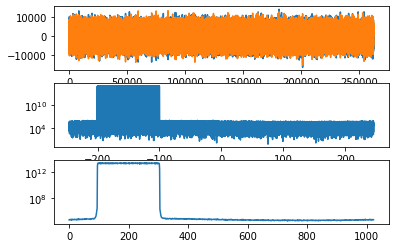

In [18]:
dac = readback_dac()
print(max(np.abs(dac)))
phase = np.angle(dac)
print(phase[0:10])
print(phase[-10:])
plt.subplot(311)
plt.plot(dac.real)
plt.plot(dac.imag)
plt.subplot(312)
dac_spec = np.abs(np.fft.fft(dac))**2
spec_freqs = np.fft.fftfreq(len(dac_spec),1/(ADC_SAMPLE_RATE_MHZ / ADC_DECIMATION))
plt.semilogy(np.fft.fftshift(spec_freqs), np.fft.fftshift(dac_spec))
plt.subplot(313)
p = do_pfb(dac)
plt.semilogy(np.fft.fftshift(p))
plt.show()

# ADC DATA

In [20]:
def get_snap_data(n_points=-1):
  d, t = fpga.snapshots.adc_snapshot.read_raw(man_trig=True)
  v = struct.unpack('>%dh' % (d['length']//2), d['data'])
  vi = np.array(v[0::2], dtype=int)
  vq = np.array(v[1::2], dtype=int)
  if n_points > 0:
    vi = vi[0:n_points]
    vq = vq[0:n_points]
  return vi, vq

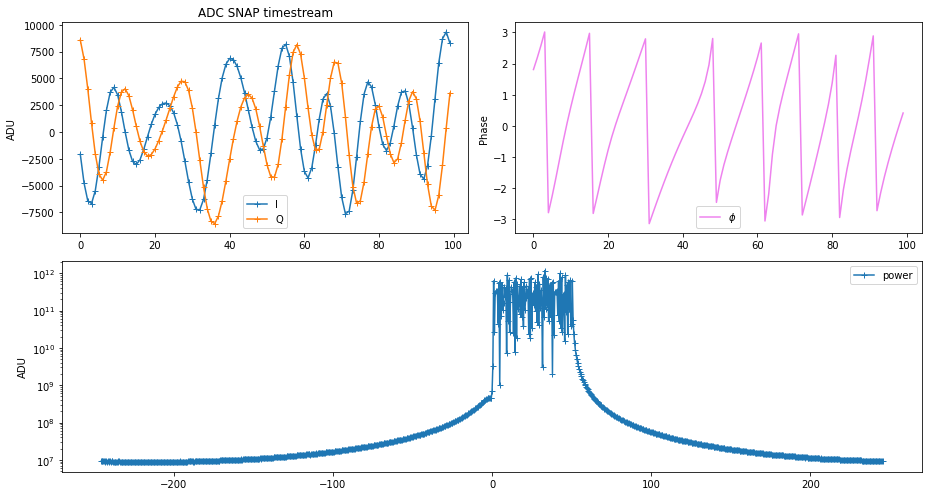

In [54]:
I3, Q3 = get_snap_data(NFFT)

plt.figure(figsize=(13,7))
c = slice(0,100)

plt.subplot(221)
plt.plot(I3[c],"-+",label="I")
plt.plot(Q3[c],"-+",label="Q")
plt.title("ADC SNAP timestream")
plt.ylabel("ADU")
plt.legend()

plt.subplot(222)
plt.plot(np.arctan2(Q3[c],I3[c]),color="violet",label=r'$\phi$')
plt.ylabel("Phase")
plt.legend()

plt.subplot(2,2,(3,4))
spec=np.fft.fft(I3+1j*Q3)
spec_freqs = np.fft.fftfreq(len(I3),1/(ADC_SAMPLE_RATE_MHZ / ADC_DECIMATION))
spec=np.abs(spec) # |spec|
plt.semilogy(np.fft.fftshift(spec_freqs), np.abs(np.fft.fftshift(spec))**2,"-+",label="power")
#plt.semilogy(np.abs(spec)**2,"-+",label="power")

plt.ylabel("ADU")
plt.legend()
plt.tight_layout()
# plt.savefig("ADCsnap.pdf")
plt.show()

## Polyphase Filterbank Snap

In [131]:
# make sure to toggle sync (gpio) first
def get_pfb_data():
    d, t = fpga.snapshots.pfb_snapshot.read_raw()
    v = np.array(struct.unpack('>%dh' % (d['length']//2), d['data']), dtype='int32')
    # Build complex values
    cv = np.zeros(len(v)//2, dtype=complex)
    cv.real = v[0::2]
    cv.imag = v[1::2]
    cv *= 2**2
    return cv

In [142]:
a = fpga.read_uint('fft_of_cnt')
time.sleep(1)
b = fpga.read_uint('fft_of_cnt')
print(b-a)

0


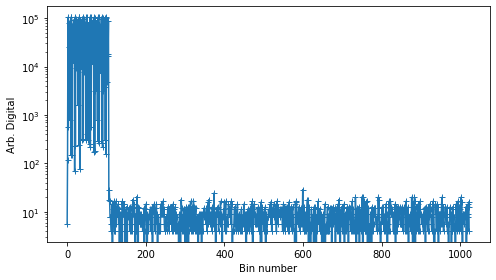

In [140]:
fpga.write_int('fft_shift', 0b111)
fpga.write_int('sync', 0)
fpga.write_int('sync', 1)
fpga.write_int('sync', 0)

#SPECpfb = np.fft.fftshift(get_pfb_data()[0:NFFT])
SPECpfb = get_pfb_data()[0:NFFT]

mag = abs(SPECpfb)

spec_freqs = np.fft.fftfreq(len(SPECpfb),1/(ADC_SAMPLE_RATE_MHZ / ADC_DECIMATION))
plt.figure(figsize=(7,4))
#plt.title(r"$f_s=2048MHZ, N_{bins}=512$"+"(7 tones, external hardware loopback)")
plt.ylabel("Arb. Digital")
#plt.plot(mag)
shift = False
if shift:
    plt.semilogy(np.fft.fftshift(spec_freqs), np.fft.fftshift(mag),"-+",label='PFB mag')
    plt.xlabel("Frequency (MHz)")
else:
    plt.semilogy(mag,"-+",label='PFB mag')
    plt.xlabel("Bin number");

#plt.xlim(758,778)
#plt.plot(Qpfb_f,"-+",label='Q')
#plt.legend()
plt.tight_layout()
#plt.savefig("pfb_snap.pdf")
plt.show()

In [141]:
SPECpfb

array([-4.0000e+00+4.0000e+00j, -2.8000e+01-1.1200e+02j,
        1.4816e+04+1.0278e+05j, ..., -4.0000e+00+0.0000e+00j,
        0.0000e+00+1.6000e+01j, -4.0000e+00+1.2000e+01j])

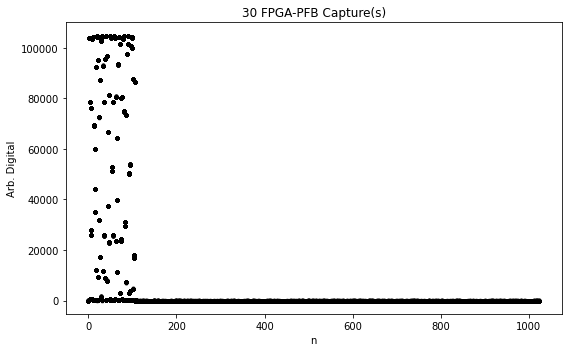

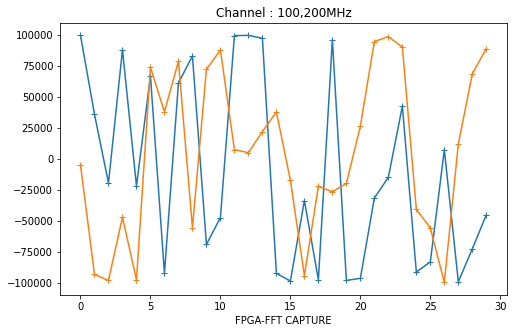

In [143]:
plt.figure(figsize=(8,5))
M=30
k= 100
#k+=512
chnl_ts = np.zeros(M,dtype=complex)
plt.title(f"{M} FPGA-PFB Capture(s)")
for i in range(M):
    SPECpfb = get_pfb_data()
    chnl_ts[i] = SPECpfb[k]
    mag = abs(SPECpfb)
    #print(mag[k])
    #plt.title(r"$f_s=2048MHZ, N_{bins}=512$"+"(7 tones, external hardware loopback)")
    plt.xlabel("n"); plt.ylabel("Arb. Digital")
    #plt.plot(mag)
    plt.plot(mag[1024*0:1*1024],".",color="black",alpha=0.5)
    plt.plot(mag[1024*1:2*1024],".",color="black",alpha=0.5)
    plt.plot(mag[1024*2:3*1024],".",color="black",alpha=0.5)
    plt.plot(mag[1024*3:4*1024],".",color="black",alpha=0.5)
    #plt.xlim(0,1024)
    plt.grid()
    plt.tight_layout()
#plt.axvline(1024+k,color="red",alpha=0.2)
plt.show()

plt.figure(figsize=(8,5));plt.title(f"Channel : {k},{(2*k)}MHz")
plt.plot(chnl_ts.real,"-+")
plt.plot(chnl_ts.imag,"-+")
plt.xlabel("FPGA-FFT CAPTURE")
plt.show()

# Digital Down Conversion

In [145]:
def get_ddc_data():
    d, _ = fpga.snapshots.ddc_snapshot.read_raw()
    v = struct.unpack('>%dh' % (d['length']//2), d['data'])
    # Build complex
    cv = np.zeros(len(v)//2, dtype=complex)
    cv.real = v[0::2]
    cv.imag = v[1::2]
    cv *= 2**3
    return cv

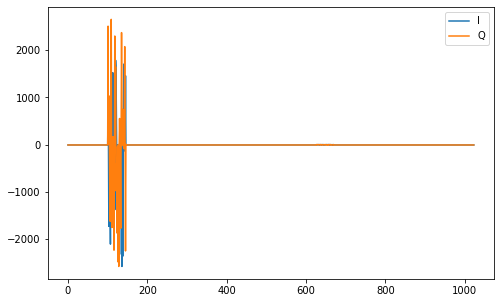

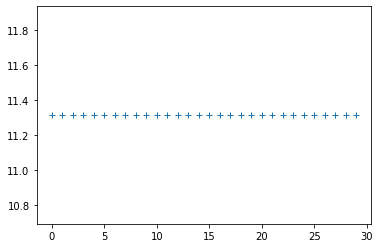

In [146]:
ddc_IQ_dat = get_ddc_data()

Iddc_f = ddc_IQ_dat.real[0:1024]
Qddc_f = ddc_IQ_dat.imag[0:1024]

plt.figure(figsize=(8,5))

#plt.plot(Iddc_f[50:150],label='I')
#plt.plot(Qddc_f[50:150],label='Q')
plt.plot(Iddc_f,label='I')
plt.plot(Qddc_f,label='Q')
plt.legend()
plt.show()

plt.figure()
plt.plot(abs(Iddc_f+1j*Iddc_f)[30:60],"+")
plt.show()

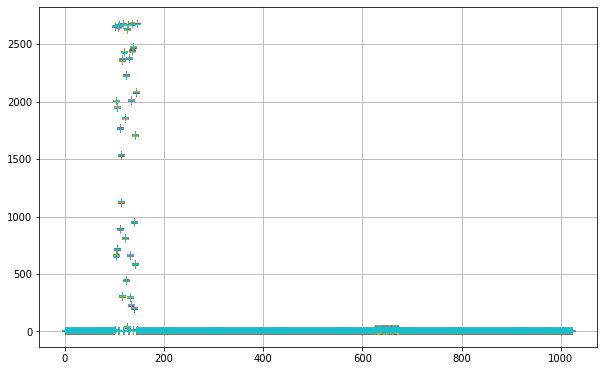

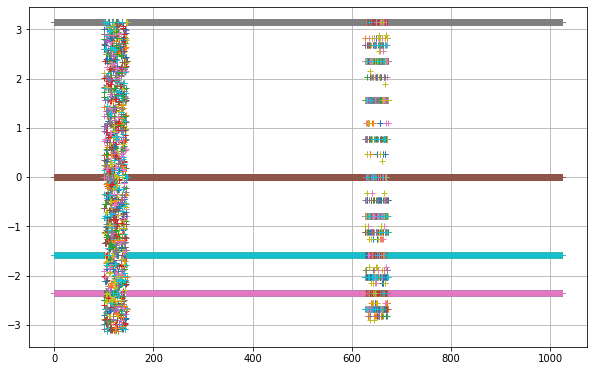

In [147]:
plt.figure(figsize=(1.25*8,1.25*5))

for n in range(50):
    sleep(0.005)
    ddc_IQ_dat = get_ddc_data()

    Iddc_f = ddc_IQ_dat.real[0:1024]
    Qddc_f = ddc_IQ_dat.imag[0:1024]

    plt.plot(abs(Iddc_f+1j*Qddc_f),"+")
    #plt.xlim(210,230)
plt.grid()

plt.figure(figsize=(1.25*8,1.25*5))

for n in range(50):
    sleep(0.005)
    ddc_IQ_dat = get_ddc_data()

    Iddc_f = ddc_IQ_dat.real[0:1024]
    Qddc_f = ddc_IQ_dat.imag[0:1024]

    plt.plot(np.angle(Iddc_f+1j*Qddc_f),"+")
    #plt.xlim(210,230)
plt.grid()

plt.show()

## Vector Accumulate and Downsample

In [21]:
def get_accum_data():
    fpga.snapshots.acc_snapshot0.arm() # Arms 0 and 1
    ss0, _ = fpga.snapshots.acc_snapshot0.read_raw(arm=False)
    ss1, _ = fpga.snapshots.acc_snapshot1.read_raw(arm=False)
    v0 = struct.unpack('<%di' % (ss0['length']//4), ss0['data'])
    v1 = struct.unpack('<%di' % (ss1['length']//4), ss1['data'])
    # Build complex
    cv = np.zeros(len(v0), dtype=complex)
    cv.real = v0
    cv.imag = v1
    return cv

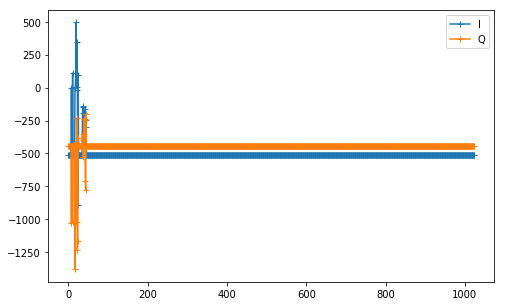

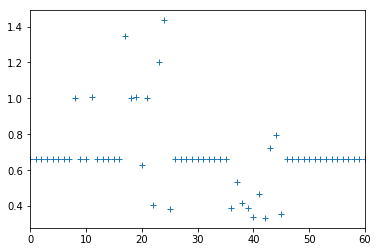

In [35]:
accum_IQ_dat = get_accum_data()
Iacc_f = accum_IQ_dat.real
Qacc_f = accum_IQ_dat.imag
Ia, Qa = np.array(Iacc_f), np.array(Qacc_f)

plt.figure(figsize=(8,5))
plt.plot(Ia[0*1024:1024],"-+",label='I')
plt.plot(Qa[0*1024:1024],"-+",label='Q')
plt.legend()
#plt.xlim(60-10,len(freqs)+60+10)
plt.show()

plt.figure()
IQMAG=np.sqrt(Ia**2+Qa**2)
plt.plot(IQMAG[0*1024:1024]/2**10,"+")
plt.xlim(0,len(freqs)+50)
plt.show()

In [ ]:
D=Ia[0*1024:1024]
for d in D:
    print(f"{int(d):b}")


In [ ]:
plt.figure(figsize=(8,5))
plt.plot(Ia[1024*3:4*1024],"-+",label='I')
plt.plot(Qa[1024*3:4*1024],"-+",label='Q')
plt.xlim(60-10,len(freqs)+60+10)
plt.legend()
#plt.xlim(60-10,len(freqs)+60+10)
plt.show()

plt.figure()
IQMAG=np.sqrt(Ia**2+Qa**2)
#plt.plot(IQMAG[1024*3:4*1024],"+")
plt.plot(IQMAG,"+")
#plt.xlim(60-10,len(freqs)+60+10)
plt.show()

In [ ]:
(IQMAG[60:60+len(freqs)]*1e-4)

In [ ]:
phi

In [ ]:
plt.figure()
for _ in range(5):
    accum_IQ_dat = get_accum_data()
    Iacc_f = accum_IQ_dat.real
    Qacc_f = accum_IQ_dat.imag
    Ia, Qa = np.array(Iacc_f), np.array(Qacc_f)

    IQMAG=np.sqrt(Ia**2+Qa**2)
    plt.plot(IQMAG,"+",color="black",alpha=0.2)
plt.xlim(60-10,60+len(freqs)+10)
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(Ia[0:70],label='I')
plt.plot(Qa[0:70],label='Q')
plt.legend()
#plt.xlim(0,1054)
plt.show()

In [ ]:
Ia[239]

In [ ]:
Is=[]
Qs=[]
xs=[]
for _ in range(150):
    x=get_accum_data()
    I=x.real
    Q=x.imag
    #print(x[150:155])
    Is.append(I)
    Qs.append(Q)
    xs.append(x)

In [ ]:
accum_IQ_dat[0:10]

In [ ]:
# mag_shift = np.zeros(1024)
l=2
for j in range(10):
    print("run {}".format(j))
    print("="*25)
    shiftmax=0
    for i in range(0, 512):
        dds_shift.write(0x00,i)
        sleep(0.75)
        #if i%50 == 0:
        #  print(i)
        accum_IQ_dat = get_accum_data()
        Iacc_f = accum_IQ_dat.real[1024*l:1024*(l+1)].astype("float")
        Qacc_f = accum_IQ_dat.imag[1024*l:1024*(l+1)].astype("float")
        MAG =  np.max(np.sqrt(Iacc_f**2+Qacc_f**2))
        #print(MAG)
        if MAG > shiftmax:
            shiftmax=MAG
            print("shift: {} maxshift: {}".format(i, shiftmax))

In [ ]:
 dds_shift.write(0x00,270) # 451 ,133  233

In [ ]:
(400e6)/900

In [ ]:
#114

# 40-60
# 210-260
# 340 - 400

In [ ]:
def find_res(center=1000,res=30e-3,span=0.512,ntones=1000,centered=False):
    ##############################
    #  Set VALON LO Value        #
    ############################## 
    
    offs=60
    NN=len(freqs)
    c=slice(offs,offs+NN)
    AVGS = 1
    
    source_channel=2
    LO_power = 0 # dBm
    valon=Valon.Synthesizer('/dev/ttyUSB0')
    if not centered:
        dfs=np.linspace(0,span,int(span/res))
    else:
        dfs=np.linspace(-span//2,span//2,int(span/res))
    valon.set_rf_level(source_channel,LO_power)
    
    data=np.zeros(shape=(len(dfs),ntones))
    f=np.zeros(shape=(len(dfs),ntones))
    
    for i,df in enumerate(dfs): 
        f_LO=center+df
        valon.set_frequency(source_channel,f_LO)
        sleep(.05)
        IQmag=np.zeros(NN)
        for _ in range(AVGS):
            accum_IQ_dat = get_accum_data(accum_snap).astype("int32")
            Ia = accum_IQ_dat[0::2].astype("float")
            Qa = accum_IQ_dat[1::2].astype("float")
            IQmag+=np.sqrt(Ia**2+Qa**2)[c]
        IQmag/=AVGS
        data[i]=IQmag
        f[i]=np.flip(freqs+df*1e6)

    valon.set_frequency(source_channel,center)
    return f, data
ff,dd=find_res(center=950,res=.01,span=1.96,ntones=len(freqs))

In [ ]:
ddtestcal=dd.flatten('F') #/ddcal.flatten('F')
# ddtestlog=10*np.log10(ddtest)
plt.figure(figsize=(15,5))
plt.plot(200+1*ff.flatten('F')*1e-6,ddtestcal,"+")
# resonators=np.array([477.5,639,774,889.5])-670